In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

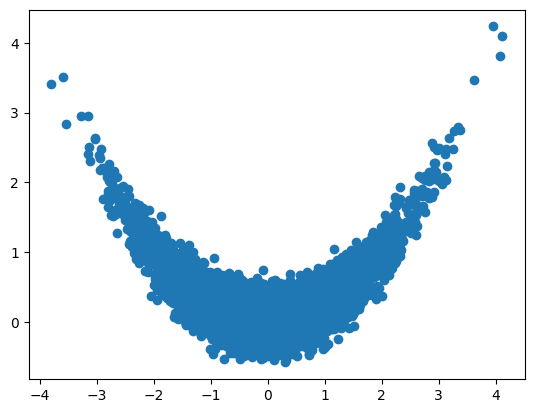

In [3]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

# Sample data
X = sample_banana(10000)
plt.scatter(X[:,0], X[:,1])

In [2]:
class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims):
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims
        self.alpha = 1.0

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()


        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx==0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None

        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)

            if i==0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights and output layer.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad():
            for i in range(1, len(self.Wz_layers)):
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
            
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.copy_(torch.abs(self.output_layer.weight))



In [3]:
from scipy.optimize import newton
from scipy.optimize import root

np.random.seed(42)
torch.manual_seed(42)
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
S = base.sample((1000,)).cpu().numpy()
# Phi = X^8 / 8 + X^4 /4  + Y^4 / 4
# T = <X^7 + X^3, Y^3>
# T-1 =  <A : A - (X^7 + X^3) = 0, Y^(1/3)>

# def f(X, a):
#     return X**7 + X**3 - a
# def n_th_root(x, n):
#     return np.sign(x) * np.power(np.abs(x), 1.0/n)

# def T_inv(xy):
#     x = xy[:,0]
#     y = xy[:,1]
#     X_inv = newton(f, x0=x, args=(x ,), maxiter=100_000)
#     Y_inv = n_th_root(y, 3)
#     return np.stack([X_inv, Y_inv], axis=1)


# Phi2 = X^4 + X^2 Y^2 + Y^4 + (X + Y) ^ 4 + (X - Y) ^ 4
# T2 = <4 * X^3 + 2 * X * Y^2 + 4 * (X + Y)^3 + 4 * (X - Y)^3, 2 * X^2 * Y + 4 * Y^3 + 4 * (X + Y)^3 - 4 * (X - Y)^3> 


def T(xy):
    x = xy[:, 0]
    y = xy[:, 1]
    Tx = 4 * x**3 + 2 * x * y**2 + 4 * (x + y)**3 + 4 * (x - y)**3
    Ty = 2 * x**2 * y + 4 * y**3 + 4 * (x + y)**3 - 4 * (x - y)**3
    return np.stack([Tx, Ty], axis=1)

def inv_T(tx_ty):
    if tx_ty.ndim == 1:
        tx_ty = tx_ty.reshape(1, -1)
    
    results = []
    for i in range(len(tx_ty)):
        x0 = tx_ty[i].copy()  # initial guess
        def f(xy):
            xy_2d = xy.reshape(1, -1)
            return (T(xy_2d) - tx_ty[i]).ravel()
        sol = root(f, x0)
        results.append(sol.x)
    
    return np.array(results)
    

X = inv_T(S)
np.savez('./X_data.npz', X=X)

In [5]:
# test the inversion
points = [
    np.array([0.215, -0.215]),
    np.array([0.5, 0.5]),
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([-1.0, -1.0])
]
for point in points:
    T_point = T(point.reshape(1, -1))
    T_inv_point = inv_T(T_point)
    print(f"Original: {point}, T: {T_point.ravel()}, T_inv: {T_inv_point.ravel()}")

Original: [ 0.215 -0.215], T: [ 0.37765825 -0.37765825], T_inv: [ 0.215 -0.215]
Original: [0.5 0.5], T: [4.75 4.75], T_inv: [0.5 0.5]
Original: [0. 0.], T: [0. 0.], T_inv: [0. 0.]
Original: [1. 1.], T: [38. 38.], T_inv: [1. 1.]
Original: [-1. -1.], T: [-38. -38.], T_inv: [-1. -1.]


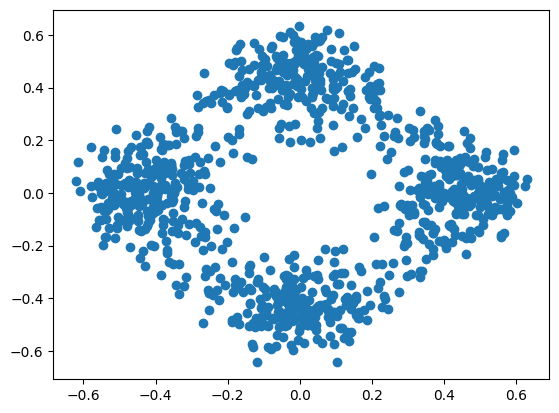

In [4]:
plt.scatter(X[:,0], X[:,1])

In [14]:
import copy
class DeepConvexFlow(torch.nn.Module):
    """
    Deep convex potential flow parameterized by an input-convex neural network
    """

    def __init__(self, icnn, dim, n_icnns=3, unbiased=False, no_bruteforce=True, rtol=0.0, atol=1e-3,
                 bias_w1=0.0, trainable_w0=True):
        super(DeepConvexFlow, self).__init__()

        # Create multiple ICNNs if n_icnns > 1, otherwise keep single ICNN
        if n_icnns > 1:
            self.icnn = nn.ModuleList([copy.deepcopy(icnn) for _ in range(n_icnns)])
            # Create separate beta parameters for each ICNN
            self.beta = nn.Parameter(torch.zeros(n_icnns) + bias_w1)
        else:
            self.icnn = icnn
            self.beta = nn.Parameter(torch.zeros(1) + bias_w1)
        
        self.n_icnns = n_icnns
        self.no_bruteforce = no_bruteforce
        self.rtol = rtol
        self.atol = atol

        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        # Keep w1 for backward compatibility or remove if not needed
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)
        self.bias_w1 = bias_w1
        
    def get_potential(self, x):
        n = x.size(0)
        
        if self.n_icnns > 1:
            # Weighted sum of multiple ICNNs with individual beta weights
            icnn_weighted_sum = 0
            for i, icnn in enumerate(self.icnn):
                
                icnn_output = icnn(x)
            
                icnn_weighted_sum += F.softplus(self.beta[i]) * icnn_output
        else:
            # Single ICNN case
            
            icnn_output = self.icnn(x)
            
            icnn_weighted_sum = F.softplus(self.beta[0]) * icnn_output
        
        return icnn_weighted_sum + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2
    
    
    def reverse(self, y, max_iter=1000000, lr=1.0, tol=1e-12, x=None, **kwargs):
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Solves x such that f(x) - y = 0
            # <=> Solves x such that argmin_x F(x) - <x,y>
            F = self.get_potential(x)
            loss = torch.sum(F) - torch.sum(x * y)
            x.grad = torch.autograd.grad(loss, x)[0].detach()
            return loss

        optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, tolerance_grad=tol,
                                      tolerance_change=tol)

        optimizer.step(closure)

        error_new = (self.forward_transform(x)[0] - y).abs().max().item()
        # if error_new > math.sqrt(tol):
        #     print('inversion error', error_new, flush=True)
        torch.cuda.empty_cache()
        gc.collect()

        return x

    def forward(self, x):
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f

    def forward_transform(self, x, logdet=0, extra=None):

        return self.forward_transform_bruteforce(x, logdet)

    def forward_transform_bruteforce(self, x, logdet=0):
        warnings.warn('brute force')
        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x.requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

            # TODO: compute Hessian in block mode instead of row-by-row.
            f = f.reshape(bsz, -1)
            H = []
            for i in range(f.shape[1]):
                retain_graph = self.training or (i < (f.shape[1] - 1))
                H.append(
                    torch.autograd.grad(f[:, i].sum(), x, create_graph=self.training, retain_graph=retain_graph)[0])

            # H is (bsz, dim, dim)
            H = torch.stack(H, dim=1)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + torch.slogdet(H).logabsdet

    def extra_repr(self):
        return f"ConjGrad(rtol={self.rtol}, atol={self.atol})"


In [17]:
icnn = ICNN(n_dim=2, hidden_dims=[2,2]).to(device)
model = DeepConvexFlow(icnn, 2, n_icnns=1).to(device)

#TODO: make the training step by step instead of all at once
def train(X, model, epochs=200, lr=5e-2, dim=2):
    EPOCHS = epochs
    LR=lr
    base = torch.distributions.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
    optimizer = torch.optim.NAdam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.25)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=1_000, shuffle=True)

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)


            y, logdet = model.forward_transform(x_batch, logdet=0.0)
            logp0 = base.log_prob(y)
            logpx = logp0 + logdet

            loss = -logpx.mean()  # NLL = reverse KL
            #l2 error
            


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if hasattr(model.icnn, '__iter__'):  # Multiple ICNNs case
                for icnn in model.icnn:
                    icnn.enforce_constraints()
            else:  # Single ICNN case
                model.icnn.enforce_constraints()



            total_loss += loss.item() * x_batch.size(0)
        
        scheduler.step()

        


        
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}")

train(X, model, epochs=1_000, lr=5e-2)

/tmp/ipykernel_1490/466893492.py:88: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/1000, NLL = 1.7090
Epoch 10/1000, NLL = 1.4293
Epoch 15/1000, NLL = 1.1538
Epoch 20/1000, NLL = 0.9376
Epoch 25/1000, NLL = 0.7915
Epoch 30/1000, NLL = 0.6992
Epoch 35/1000, NLL = 0.6312
Epoch 40/1000, NLL = 0.5593
Epoch 45/1000, NLL = 0.4961
Epoch 50/1000, NLL = 0.4325
Epoch 55/1000, NLL = 0.4015
Epoch 60/1000, NLL = 0.3636
Epoch 65/1000, NLL = 0.3403
Epoch 70/1000, NLL = 0.2928
Epoch 75/1000, NLL = 0.2882
Epoch 80/1000, NLL = 0.2436
Epoch 85/1000, NLL = 0.2380
Epoch 90/1000, NLL = 0.2002
Epoch 95/1000, NLL = 0.1990
Epoch 100/1000, NLL = 0.1571
Epoch 105/1000, NLL = 0.1601
Epoch 110/1000, NLL = 0.1144
Epoch 115/1000, NLL = 0.1216
Epoch 120/1000, NLL = 0.0734
Epoch 125/1000, NLL = 0.0846
Epoch 130/1000, NLL = 0.0353
Epoch 135/1000, NLL = 0.0498
Epoch 140/1000, NLL = 0.0006
Epoch 145/1000, NLL = 0.0176
Epoch 150/1000, NLL = -0.0302
Epoch 155/1000, NLL = -0.0115
Epoch 160/1000, NLL = -0.0573
Epoch 165/1000, NLL = -0.0374
Epoch 170/1000, NLL = -0.0807
Epoch 175/1000, NLL = -0.0603

In [9]:
train(X, model, epochs=50, lr=5e-3)

/tmp/ipykernel_1490/466893492.py:88: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/50, NLL = 0.5309
Epoch 10/50, NLL = 0.5573
Epoch 15/50, NLL = 0.5340
Epoch 20/50, NLL = 0.5440
Epoch 25/50, NLL = 0.5530
Epoch 30/50, NLL = 0.5418
Epoch 35/50, NLL = 0.5397
Epoch 40/50, NLL = 0.5421
Epoch 45/50, NLL = 0.5552
Epoch 50/50, NLL = 0.5707


# The maps test

In [20]:
# plot the ICNN potential function
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X_grid, Y_grid = np.meshgrid(x, y)

ICNN_outputs = []
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
        point = torch.tensor([[X_grid[i, j], Y_grid[i, j]]], dtype=torch.float32, device=device)
        ICNN_outputs.append(model.icnn(point))

ICNN_outputs

NotImplementedError: Module [ModuleList] is missing the required "forward" function

In [9]:
p = model.forward(torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch.float32, device=device)).detach().cpu().numpy()
p.shape

NameError: name 'X_grid' is not defined

In [ ]:
plt.scatter(X[:,0], X[:,1])

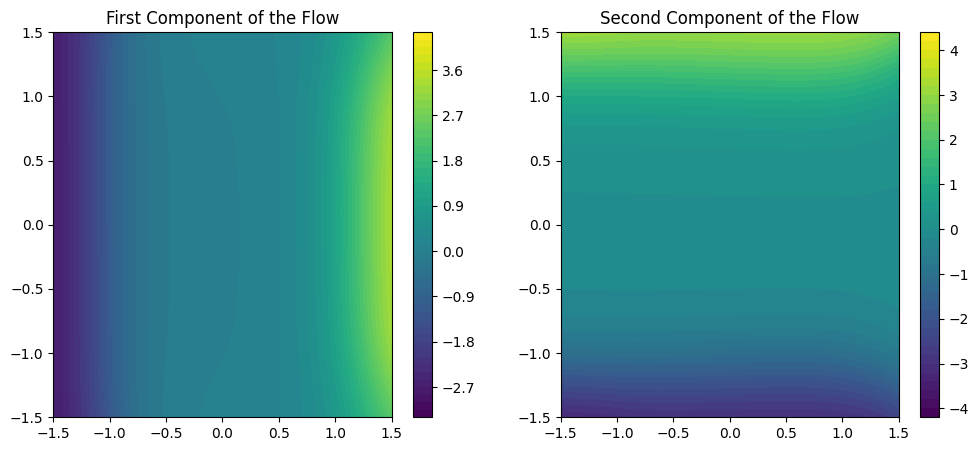

In [ ]:
# Generate first and second components of the flow give the grid
# plot the ICNN potential function
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X_grid, Y_grid = np.meshgrid(x, y)
p = model.forward(torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch.float32, device=device)).detach().cpu().numpy()
p1 = p[:,0].reshape(X_grid.shape)
p2 = p[:,1].reshape(Y_grid.shape)
p_h = T(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1))
p1_h = p_h[:,0].reshape(X_grid.shape)
p2_h = p_h[:,1].reshape(Y_grid.shape)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, p1, levels=50, cmap='viridis')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()
plt.title('First Component of the Flow')
plt.subplot(1, 2, 2)
plt.contourf(X_grid, Y_grid, p2, levels=50, cmap='viridis')
#plt.contourf(X_grid, Y_grid, p2_h, levels=50, cmap='viridis')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()
plt.title('Second Component of the Flow')
plt.show()

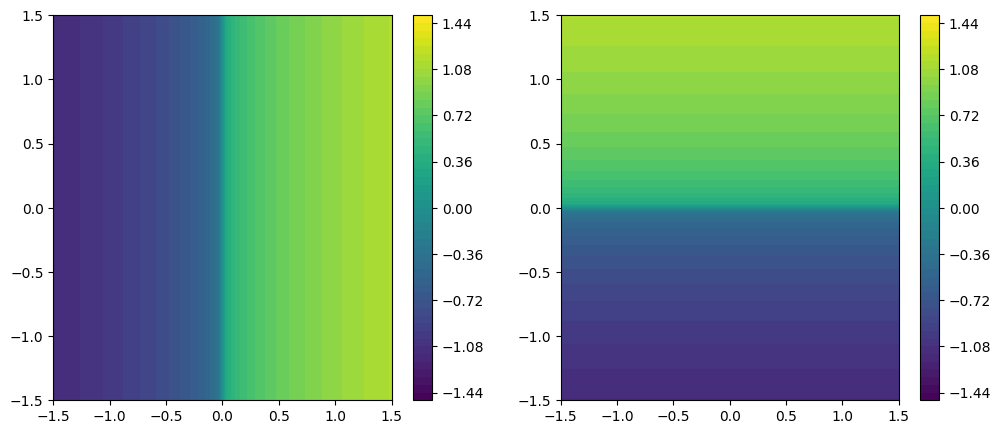

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, p1_h, levels=50, cmap='viridis')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.contourf(X_grid, Y_grid, p2_h, levels=50, cmap='viridis')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()

plt.show()

# Sampling

/tmp/ipykernel_1490/466893492.py:88: UserWarning: brute force
  warnings.warn('brute force')


(-1.0, 1.0)

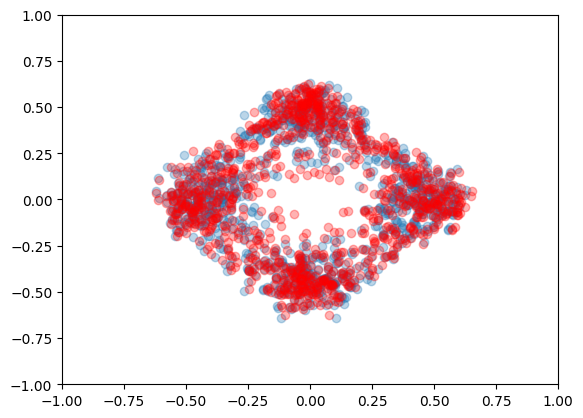

In [18]:
samples = model.reverse(torch.tensor(S, device=device), max_iter=5000, lr=1.0, tol=1e-12).cpu().detach().numpy()

plt.scatter(X[:,0], X[:,1], alpha=0.3)
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, color='red')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [32]:
# l2 error between samples and X
l2_error = np.mean(np.linalg.norm(samples - X, axis=1))
print(f"L2 error between samples and X: {l2_error}")

L2 error between samples and X: 0.11881382030225168


BIG MAP: 0.024022065227873673
SMALL_1: 0.043030126088195654
SMALL_2: 0.022045702105530748
SMALL_2_F: 0.10815220566597446
BIG_MAP_F: 0.11881382030225168

In [26]:
# plot the parameters of the ICNN
for name, param in model.icnn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# count the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {total_params}')

Wx_layers.0.weight tensor([[4.5264, 0.0106],
        [0.0137, 0.0068]], device='cuda:0')
Wx_layers.0.bias tensor([-2.6813,  0.0187], device='cuda:0')
Wx_layers.1.weight tensor([[-0.1123,  4.5996],
        [-0.1444, -4.5467]], device='cuda:0')
Wx_layers.1.bias tensor([1.7869, 1.8778], device='cuda:0')
Wx_layers.2.weight tensor([[ 0.3123,  0.3807],
        [-4.9954, -0.1183]], device='cuda:0')
Wx_layers.2.bias tensor([ 0.6467, -1.9345], device='cuda:0')
Wz_layers.0.weight tensor([], device='cuda:0', size=(2, 0))
Wz_layers.0.bias tensor([0., 0.], device='cuda:0')
Wz_layers.1.weight tensor([[0.5713, 0.0176],
        [0.5892, 1.0515]], device='cuda:0')
Wz_layers.1.bias tensor([2.1274, 1.6800], device='cuda:0')
Wz_layers.2.weight tensor([[1.4245, 1.5442],
        [0.1502, 0.1270]], device='cuda:0')
Wz_layers.2.bias tensor([ 0.5650, -2.6433], device='cuda:0')
b.0 tensor([-2.8433, -0.3156], device='cuda:0')
b.1 tensor([1.5474, 1.3461], device='cuda:0')
b.2 tensor([ 0.5651, -2.6169], device='cu

In [ ]:
train(X, model, epochs=50, lr=1e-3)

/tmp/ipykernel_6732/466893492.py:88: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/50, NLL = 1.5135
Epoch 10/50, NLL = 1.5135
Epoch 15/50, NLL = 1.5134
Epoch 20/50, NLL = 1.5134
Epoch 25/50, NLL = 1.5134
Epoch 30/50, NLL = 1.5132
Epoch 35/50, NLL = 1.5133
Epoch 40/50, NLL = 1.5132


KeyboardInterrupt: 

/tmp/ipykernel_1813/466893492.py:88: UserWarning: brute force
  warnings.warn('brute force')


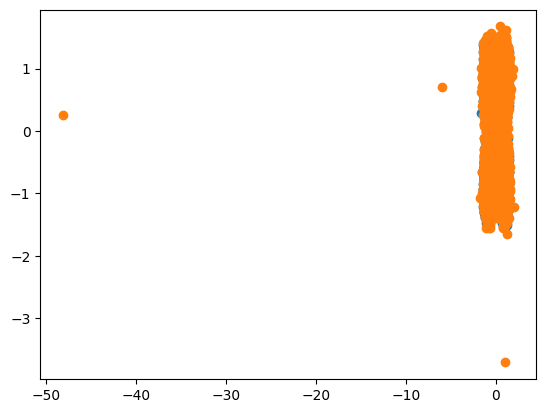

In [ ]:
plt.scatter(X[:,0], X[:,1])
Y = model.reverse(torch.tensor(S, dtype=torch.float32, device=device))
Y = Y.detach().cpu().numpy()
plt.scatter(Y[:,0], Y[:,1])
plt.xlim(-2, 1.1)
#plt.ylim(0.9, 1.1)

In [26]:
import copy
full_model = copy.deepcopy(model)

# Step-Wise training

Training with INTERLEAVED fine-tuning (reduced quadratic w0=0.1)

🎯 STAGE 1: Training ICNN 0 (active ICNNs: [0..0])

📍 Phase 1: Training ICNN 0 only


/tmp/ipykernel_1490/3272980359.py:109: UserWarning: brute force
  warnings.warn("brute force", UserWarning)


[icnn_0_solo] Epoch 010/500 - NLL = 3.000561 | β0=0.146, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 020/500 - NLL = 2.350888 | β0=0.234, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 030/500 - NLL = 1.278436 | β0=0.368, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 040/500 - NLL = 0.890020 | β0=0.510, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 050/500 - NLL = 0.573366 | β0=0.637, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 060/500 - NLL = 0.333847 | β0=0.701, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 070/500 - NLL = 0.269915 | β0=0.737, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 080/500 - NLL = 0.179837 | β0=0.778, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 090/500 - NLL = 0.130791 | β0=0.811, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 100/500 - NLL = 0.077746 | β0=0.845, β1=0.000, β2=0.000 → training ICNN 0
[icnn_0_solo] Epoch 110/500 - NLL = 0.031708 | β0=0.873, β1=

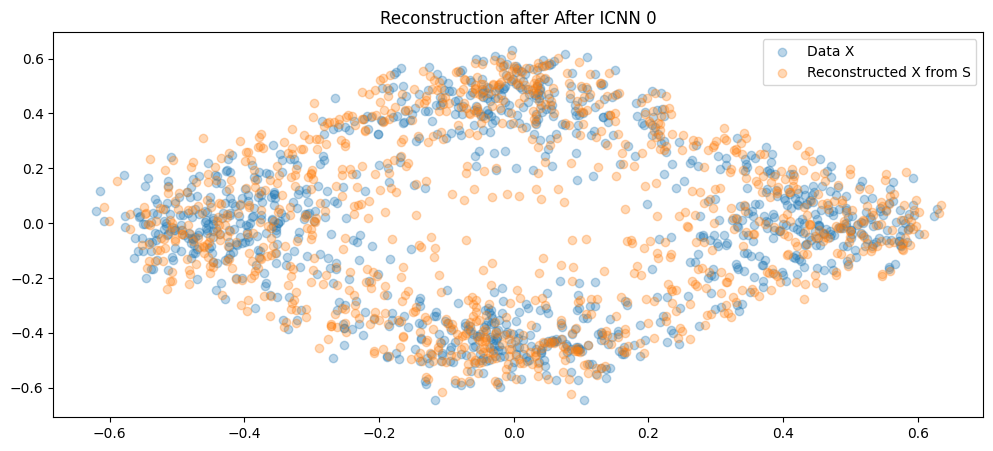


🎯 STAGE 2: Training ICNN 1 (active ICNNs: [0..1])

📍 Phase 1: Training ICNN 1 only
[icnn_1_solo] Epoch 010/500 - NLL = -0.211406 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 020/500 - NLL = -0.211427 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 030/500 - NLL = -0.211426 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 040/500 - NLL = -0.211432 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 050/500 - NLL = -0.211432 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 060/500 - NLL = -0.211433 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 070/500 - NLL = -0.211435 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 080/500 - NLL = -0.211436 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 090/500 - NLL = -0.211438 | β0=1.003, β1=0.100, β2=0.000 → training ICNN 1
[icnn_1_solo] Epoch 100/500 - NLL = -0.211439 | β0=1.003, β1=

KeyboardInterrupt: 

In [ ]:
import copy
import gc
import warnings
from typing import Optional, Iterable

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.func import vmap, hessian


class DeepConvexFlow(nn.Module):
    """
    Deep convex potential flow with REDUCED quadratic regularization
    """

    def __init__(
        self,
        icnn: nn.Module,
        dim: int,
        n_icnns: int = 3,
        atol: float = 1e-3,
        bias_w1: float = 0.0,
        w0_scale: float = 0.1,  # CHANGED: Much smaller quadratic weight
    ):
        super().__init__()
        self.dim = dim
        self.n_icnns = int(n_icnns)
        self.atol = atol
        self._active = n_icnns

        # ---- ICNNs and beta weights ----
        if self.n_icnns > 1:
            self.icnn = nn.ModuleList([copy.deepcopy(icnn) for _ in range(self.n_icnns)])
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))
                                          for _ in range(self.n_icnns)])
        else:
            self.icnn = icnn
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))])

        # CHANGED: Small fixed quadratic term (0.1 instead of 1.0)
        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.tensor(1)) - 1))

    @torch.no_grad()
    def set_active(self, count: int):
        self._active = max(0, min(int(count), self.n_icnns))

    def get_potential(self, x: torch.Tensor) -> torch.Tensor:
        n = x.shape[0]
        # CHANGED: Smaller quadratic regularization
        quad = self.w0 * (x.reshape(n, -1).pow(2).sum(dim=1, keepdim=True) / 2.0)

        if self.n_icnns > 1:
            icnn_weighted_sum = 0.0
            n_active = getattr(self, "_active", self.n_icnns)
            for i in range(n_active):
                icnn_out = self.icnn[i](x)
                icnn_weighted_sum = icnn_weighted_sum + F.softplus(self.beta[i]) * icnn_out
        else:
            icnn_weighted_sum = F.softplus(self.beta[0]) * self.icnn(x)

        return icnn_weighted_sum + quad

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]
        return f

    def reverse(self, y: torch.Tensor, max_iter: int = 100_000, lr: float = 1.0,
                tol: float = 1e-12, x: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            Fval = self.get_potential(x)
            loss = Fval.sum() - (x * y).sum()
            (grad_x,) = torch.autograd.grad(loss, (x,), retain_graph=False)
            x.grad = grad_x.detach()
            return loss

        opt = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe",
                                max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)
        opt.step(closure)

        if x.is_cuda:
            torch.cuda.empty_cache()
        gc.collect()
        return x

    def forward_transform(self, x: torch.Tensor, logdet: torch.Tensor | float = 0.0, extra=None):
        return self.forward_transform_bruteforce(x, logdet)

    def _batch_logdet_psd(self, H: torch.Tensor, jitter: float) -> torch.Tensor:
        B, D, _ = H.shape
        I = torch.eye(D, dtype=H.dtype, device=H.device).expand(B, D, D)
        Hj = H + jitter * I

        L, info = torch.linalg.cholesky_ex(Hj)
        chol_logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L, dim1=-2, dim2=-1)), dim=-1)

        sign, slog = torch.linalg.slogdet(Hj)
        ok = (info == 0) & (sign > 0)
        return torch.where(ok, chol_logdet, slog)

    def forward_transform_bruteforce(self, x: torch.Tensor, logdet: torch.Tensor | float = 0.0):
        warnings.warn("brute force", UserWarning)

        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]

        x_flat = x.reshape(bsz, -1)

        def Phi_scalar_on_flat(x_row_flat: torch.Tensor) -> torch.Tensor:
            x_row = x_row_flat.reshape(1, *input_shape)
            return self.get_potential(x_row).sum()

        H = vmap(hessian(Phi_scalar_on_flat))(x_flat)
        logdet_H = self._batch_logdet_psd(H, jitter=self.atol)

        if isinstance(logdet, (int, float)):
            logdet = torch.as_tensor(logdet, dtype=logdet_H.dtype, device=logdet_H.device)
        if logdet.ndim == 0:
            logdet = logdet.expand_as(logdet_H)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + logdet_H


# -----------------------------
# Training utilities
# -----------------------------
def _set_requires_grad(params: Iterable[torch.nn.Parameter], flag: bool):
    for p in params:
        p.requires_grad_(flag)


def _enforce_icnn_constraints(model: DeepConvexFlow):
    if isinstance(model.icnn, nn.ModuleList):
        for ic in model.icnn:
            if hasattr(ic, "enforce_constraints"):
                ic.enforce_constraints()
    else:
        if hasattr(model.icnn, "enforce_constraints"):
            model.icnn.enforce_constraints()

def train_stepwise_v3(
    X,
    model: DeepConvexFlow,
    *,
    batch_size: int = 500,
    lr: float = 2e-2,
    per_icnn_epochs: int = 60,
    finetune_epochs: int = 100,
    print_every: int = 10,
    beta_min: float = 0.1,
    visualize: bool = True,
    n_viz_samples: int = 1000,
):
    """
    Training with visualization after each stage
    """
    device = next(model.parameters()).device
    X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
    if X_tensor.ndim == 1:
        X_tensor = X_tensor.unsqueeze(1)

    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    flat_dim = X_tensor[0].numel()
    base = torch.distributions.MultivariateNormal(
        torch.zeros(flat_dim, device=device),
        torch.eye(flat_dim, device=device),
    )

    # Sample base distribution for visualization
    if visualize:
        base_samples = base.sample((n_viz_samples,))

    def make_optimizer(lr_scale=1.0):
        params = [p for p in model.parameters() if p.requires_grad]
        return torch.optim.AdamW(params, lr=lr * lr_scale, weight_decay=1e-5)

    def visualize_transformations(stage_name: str):
        """Visualize forward and inverse transformations"""
        model.eval()
        with torch.no_grad():
            x_recon = model.reverse(torch.tensor(S, dtype=torch.float32, device=device))
            x_recon = x_recon.detach().cpu().numpy()
            plt.figure(figsize=(12, 5))
            plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label='Data X')
            plt.scatter(x_recon[:, 0], x_recon[:, 1], alpha=0.3, label='Reconstructed X from S')
            plt.title(f"Reconstruction after {stage_name}")
            plt.legend()
            plt.show()
        
        model.train()

    def run_epochs(num_epochs: int, stage_name: str, target_beta_idx: int = None, 
                   finetune_previous: bool = False):
        model.train()
        optimizer = make_optimizer(lr_scale=0.5 if finetune_previous else 1.0)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        for epoch in range(1, num_epochs + 1):
            total_loss, total_count = 0.0, 0
            for (xb,) in loader:
                y, logdet = model.forward_transform(xb, logdet=0.0)
                logp0 = base.log_prob(y.reshape(y.shape[0], -1))
                loss = -(logp0 + logdet).mean()

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                optimizer.step()
                _enforce_icnn_constraints(model)

                # Enforce beta floor
                if model.n_icnns > 1:
                    with torch.no_grad():
                        min_logit = torch.log(torch.exp(torch.tensor(beta_min, device=device)) - 1)
                        for i in range(model.n_icnns):
                            if model.beta[i].requires_grad:
                                model.beta[i].data.clamp_(min=min_logit.item())

                total_loss += loss.item() * xb.size(0)
                total_count += xb.size(0)

            scheduler.step()
            
            if epoch % print_every == 0:
                avg_loss = total_loss / total_count
                if model.n_icnns > 1:
                    beta_vals = [F.softplus(b.data).item() for b in model.beta]
                    beta_str = ", ".join([f"β{i}={v:.3f}" for i, v in enumerate(beta_vals)])
                    status = "→ fine-tuning all" if finetune_previous else f"→ training ICNN {target_beta_idx}"
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f} | {beta_str} {status}")
                else:
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f}")

    print("=" * 80)
    print("Training with INTERLEAVED fine-tuning (reduced quadratic w0=0.1)")
    print("=" * 80)

    # -------------------------
    # Stage 1..K: one ICNN at a time WITH interleaved fine-tuning
    # -------------------------
    for k in range(model.n_icnns):
        print(f"\n{'='*80}")
        print(f"🎯 STAGE {k+1}: Training ICNN {k} (active ICNNs: [0..{k}])")
        print(f"{'='*80}")
        
        model.set_active(k + 1)
        _set_requires_grad(model.parameters(), False)
        
        # Phase 1: Train only the new ICNN
        print(f"\n📍 Phase 1: Training ICNN {k} only")
        if model.n_icnns > 1:
            _set_requires_grad(model.icnn[k].parameters(), True)
            model.beta[k].requires_grad_(True)
        else:
            _set_requires_grad(model.icnn.parameters(), True)
            model.beta[0].requires_grad_(True)

        run_epochs(per_icnn_epochs, f"icnn_{k}_solo", target_beta_idx=k, finetune_previous=False)

        # Phase 2: Fine-tune ALL active ICNNs together (if not the first ICNN)
        if k > 0:
            print(f"\n📍 Phase 2: Fine-tuning ICNNs [0..{k}] together")
            for i in range(k + 1):
                _set_requires_grad(model.icnn[i].parameters(), True)
                model.beta[i].requires_grad_(True)
            
            run_epochs(per_icnn_epochs // 2, f"icnn_0-{k}_joint", 
                      target_beta_idx=None, finetune_previous=True)

        # Visualize after each stage
        if visualize:
            print(f"\n📊 Visualizing transformations after STAGE {k+1}:")
            visualize_transformations(f"After ICNN {k}")

    # -------------------------
    # Final joint fine-tuning
    # -------------------------
    print("\n" + "=" * 80)
    print("🎯 FINAL: Joint fine-tuning all ICNNs")
    print("=" * 80)
    model.set_active(model.n_icnns)
    _set_requires_grad(model.parameters(), True)
    run_epochs(finetune_epochs, "final_finetune", finetune_previous=True)

    # Final visualization
    if visualize:
        print(f"\n📊 Final visualization:")
        visualize_transformations("Final Model")


# --------------------------------
# FIXED: Better initialization
# --------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_icnn = ICNN(n_dim=2, hidden_dims=[2, 2]).to(device)  # CHANGED: Larger capacity

# with torch.no_grad():
#     base_icnn.output_layer.weight.fill_(0.1)

# def create_icnn_with_noise(base_icnn, scale=0.3):  # CHANGED: More diversity
#     icnn_copy = copy.deepcopy(base_icnn)
#     with torch.no_grad():
#         for param in icnn_copy.parameters():
#             param.add_(torch.randn_like(param) * scale)
#         icnn_copy.output_layer.weight.abs_()
#     return icnn_copy

# icnn_list = [base_icnn] + [create_icnn_with_noise(base_icnn, scale=0.3) for _ in range(1)]

icnn_list = [ICNN(n_dim=2, hidden_dims=[2, 2]).to(device) for _ in range(3)]
# CHANGED: w0_scale=0.1 (much smaller quadratic), bias_w1=1.0 (encourage ICNN contribution)
model = DeepConvexFlow(
    icnn_list[0], 
    dim=2, 
    n_icnns=3, 
    bias_w1=-10000.0, 
    w0_scale=1  # Reduce quadratic dominance
).to(device)

if model.n_icnns > 1:
    model.icnn = nn.ModuleList([icnn_list[i].to(device) for i in range(model.n_icnns)])

train_stepwise_v3(
    X, 
    model, 
    lr=5e-2,
    per_icnn_epochs=500,   
    finetune_epochs=200,
    print_every=10,
    beta_min=0.1,       
    batch_size=1000,
    visualize=True,
)

In [37]:
train_stepwise_v3(
    X, 
    model, 
    lr=2e-3,              # Higher LR
    per_icnn_epochs=0,   # More training per stage
    finetune_epochs=100,  # Longer fine-tuning
    print_every=10,
    beta_min=0.1,         # Higher beta floor
    batch_size=1000,
    visualize=False,
)

Training with INTERLEAVED fine-tuning (reduced quadratic w0=0.1)

🎯 STAGE 1: Training ICNN 0 (active ICNNs: [0..0])

📍 Phase 1: Training ICNN 0 only

🎯 STAGE 2: Training ICNN 1 (active ICNNs: [0..1])

📍 Phase 1: Training ICNN 1 only

📍 Phase 2: Fine-tuning ICNNs [0..1] together

🎯 STAGE 3: Training ICNN 2 (active ICNNs: [0..2])

📍 Phase 1: Training ICNN 2 only

📍 Phase 2: Fine-tuning ICNNs [0..2] together

🎯 STAGE 4: Training ICNN 3 (active ICNNs: [0..3])

📍 Phase 1: Training ICNN 3 only

📍 Phase 2: Fine-tuning ICNNs [0..3] together

🎯 STAGE 5: Training ICNN 4 (active ICNNs: [0..4])

📍 Phase 1: Training ICNN 4 only

📍 Phase 2: Fine-tuning ICNNs [0..4] together

🎯 FINAL: Joint fine-tuning all ICNNs


/tmp/ipykernel_6732/59156382.py:109: UserWarning: brute force
  warnings.warn("brute force", UserWarning)


[final_finetune] Epoch 010/100 - NLL = 1.565581 | β0=1.545, β1=0.577, β2=0.606, β3=0.684, β4=0.705 → fine-tuning all
[final_finetune] Epoch 020/100 - NLL = 1.565644 | β0=1.545, β1=0.573, β2=0.606, β3=0.678, β4=0.697 → fine-tuning all
[final_finetune] Epoch 030/100 - NLL = 1.565335 | β0=1.544, β1=0.572, β2=0.605, β3=0.676, β4=0.694 → fine-tuning all
[final_finetune] Epoch 040/100 - NLL = 1.565398 | β0=1.543, β1=0.562, β2=0.604, β3=0.665, β4=0.690 → fine-tuning all
[final_finetune] Epoch 050/100 - NLL = 1.565135 | β0=1.543, β1=0.562, β2=0.604, β3=0.664, β4=0.689 → fine-tuning all
[final_finetune] Epoch 060/100 - NLL = 1.565021 | β0=1.543, β1=0.561, β2=0.605, β3=0.664, β4=0.687 → fine-tuning all
[final_finetune] Epoch 070/100 - NLL = 1.565000 | β0=1.543, β1=0.561, β2=0.605, β3=0.664, β4=0.687 → fine-tuning all
[final_finetune] Epoch 080/100 - NLL = 1.564979 | β0=1.543, β1=0.561, β2=0.605, β3=0.664, β4=0.687 → fine-tuning all
[final_finetune] Epoch 090/100 - NLL = 1.564942 | β0=1.543, β1=0

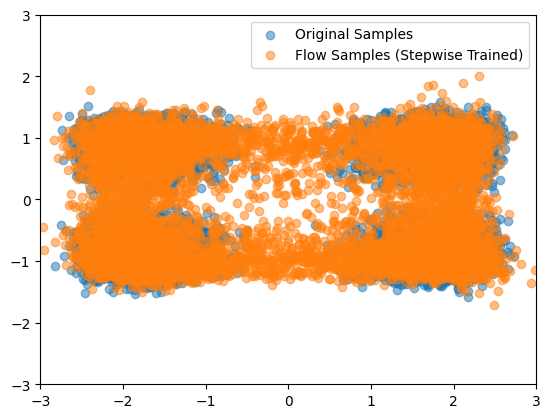

In [19]:
S_tensor = torch.tensor(S, dtype=torch.float32, device=device)
flow_samples = model.reverse(S_tensor, max_iter=10000, lr=1.0, tol=1e-10)
flow_samples = flow_samples.cpu().detach().numpy()
#flow_samples_full = full_model.reverse(S_tensor, max_iter=10000, lr=1.0, tol=1e-10)
#flow_samples_full = flow_samples_full.cpu().detach().numpy()
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], alpha=0.5, label='Flow Samples (Stepwise Trained)')
#plt.scatter(flow_samples_full[:,0], flow_samples_full[:,1], alpha=0.5, label='Flow Samples (Full Model)')
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.legend()


In [40]:
################################################
"""
NORMAL TRAINING:
0.04
0.035

STEPS WISE:
0.034
0.035
0.032
"""

################################################
print(np.mean(np.linalg.norm(flow_samples - X, axis=1)))
print(np.mean(np.linalg.norm(flow_samples_full - X, axis=1)))

0.057111613
0.03520219


In [21]:
np.mean(np.abs(flow_samples - X))

np.float32(0.019906977)

In [22]:
np.sqrt(0.039721925)

np.float64(0.1993036000678362)

In [8]:
g = np.linspace(-2, 2, 100)
grid = np.meshgrid(g, g)


In [9]:
x, y = grid
xy = np.stack([x.ravel(), y.ravel()], axis=1)

In [10]:
xy.shape

(10000, 2)

In [11]:
uv = T(xy)
u, v = uv[:,0], uv[:,1]

In [12]:
u.shape, v.shape

((10000,), (10000,))

In [13]:
model_samples = model.reverse(torch.Tensor(xy).to(device), max_iter=1000, lr=1.0, tol=1e-8)

/tmp/ipykernel_1616/2584460896.py:91: UserWarning: brute force
  warnings.warn('brute force')


In [14]:
u_hat, v_hat = model_samples[:,0].cpu().detach().numpy(), model_samples[:,1].cpu().detach().numpy()

In [15]:
mse = np.mean((xy[:, 0] - u_hat)**2 + (xy[:, 1] - v_hat)**2)
print("MSE between original and reconstructed grid points:", mse)

MSE between original and reconstructed grid points: 0.2704644741812784


In [16]:
mse_optimal = np.mean((xy[:,0] - u)**2 + (xy[:,1] - v)**2)
mse_optimal

np.float64(0.2606559358124673)

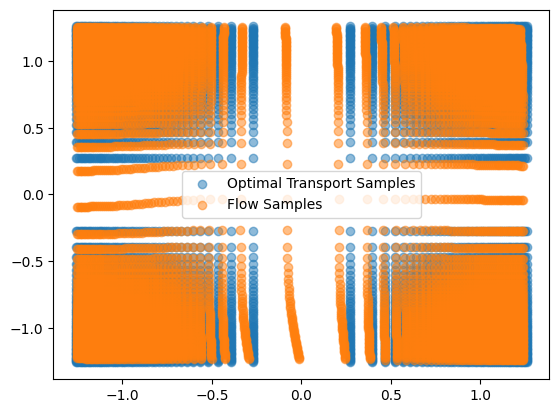

In [17]:
plt.scatter(u, v, alpha=0.5, label='Optimal Transport Samples')
plt.scatter(u_hat, v_hat, alpha=0.5, label='Flow Samples')
plt.legend()